# functions

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# insert this line of code to import the different function that we will use (they are functions that we saved in the files .py)
import sys
sys.path.insert(0,'/content/drive/MyDrive/tesi_UBFC-RPPG/function')

In [3]:
pip install mediapipe

In [4]:
pip install heartpy

In [ ]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import mediapipe as mp
import statistics
from shapely.geometry import Polygon, Point
from lpa_ici import *
import heartpy as hp
import os

#from SIGNAL_extraction_function import *
from VIDEO_load_function import *
from VIDEO_PreProcessing_function import *
#from UBFC_RPPG_function import *
from google.colab.patches import cv2_imshow

from rppg_function import *


from GREEN_1 import *
from POS_1 import *
from CHROM_1 import *
from ICA_1 import *
from PBV1 import *
from LGI1 import *

import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

In [6]:
def pixel1(results, bw_im):
    POINTS = []  # Use list for faster accumulation

    # Get image dimensions
    image_height, image_width = bw_im.shape[:2]

    # Create a grid of points (vectorized)
    x, y = np.meshgrid(np.arange(image_width), np.arange(image_height))
    grid_points = np.vstack([x.ravel(), y.ravel()]).T

    # Iterate over each polygon defined in results
    for i in results.keys():
        polygon = Polygon(results[i])

        # Get the bounding box of the polygon
        min_x, min_y, max_x, max_y = polygon.bounds

        # Limit grid points within the bounding box of the polygon
        x_min, x_max = int(max(min_x, 0)), int(min(max_x, image_width))
        y_min, y_max = int(max(min_y, 0)), int(min(max_y, image_height))

        # Extract only the grid points within the bounding box region
        bbox_mask = (x_min <= x.ravel()) & (x.ravel() <= x_max) & (y_min <= y.ravel()) & (y.ravel() <= y_max)
        bbox_points = grid_points[bbox_mask]

        # Check if points in the bounding box are inside the polygon
        inside_mask = np.array([polygon.contains(Point(p)) for p in bbox_points])
        inside_points = bbox_points[inside_mask]

        # Accumulate points inside the polygon
        POINTS.extend(map(tuple, inside_points))

    # Convert list of points to a set at the end for uniqueness
    return set(POINTS)


In [7]:
def land_coordinates(img, RGB = True):
  temp_img =  np.copy(img) #ATTENTION: IT'S CRUCIAL TO CREATE A COPY OTHERWISE WHEN WE CHANGE temp_img, also the img variable will change (same memory address)
  # Initialize MediaPipe Face Mesh
  mp_face_mesh = mp.solutions.face_mesh
  face_mesh = mp_face_mesh.FaceMesh() #refine_landmarks=True

  # Convert the BGR image to RGB
  if not(RGB):
    rgb_image = cv2.cvtColor(temp_img, cv2.COLOR_BGR2RGB)
  else:
    rgb_image = temp_img

  # Perform facial landmark detection
  results = face_mesh.process(rgb_image)

  # extract connnection
  connection_list = []
  for connection in mp_face_mesh.FACEMESH_TESSELATION:
    connection_list.append(connection)


  # Draw the landmarks on the image
  if results.multi_face_landmarks:
      for face_landmarks in results.multi_face_landmarks: # very long list of dictionary, each containing the 3D coordinates of a landmarks ({x:, y:, z:})

        landCoord = {'x': [], 'y':[], 'z':[]}

        for landmark in face_landmarks.landmark: # we are extracting only the coordinates

          # Convert normalized coordinates to pixel values
          x = landmark.x * temp_img.shape[1]
          y = landmark.y * temp_img.shape[0]
          z = landmark.z * max(temp_img.shape)

          landCoord['x'].append(x)
          landCoord['y'].append(y)
          landCoord['z'].append(z)

          # Draw the landmark on the image
          #cv2.circle(temp_img, (x, y), 1, (0, 0, 255), thickness=-1)

  # Display the image
  #cv2_imshow(temp_img[:,:,::-1])

  return landCoord, connection_list

In [8]:
def tracking_lands(marks, video_RGB): #marks [p1,p2,p3] (list)

  coordinates = {marks[0]:[],marks[1]:[],marks[2]:[]} #contain coords of landmarks over the different frames (each landmark corresponds to a specific ROI)
  for i in range(video_RGB.shape[0]):
    frame = video_RGB[i]
    land_coord, _ = land_coordinates(frame, RGB=True)
    for point in coordinates.keys():
      #coordinates[point].append((land_coord['x'][point],land_coord['y'][point],land_coord['z'][point])) #extraction coordinates single frame for each landmark
      coordinates[point].append((int(land_coord['x'][point]),int(land_coord['y'][point]))) # in this case we keep only the x,y coords in int format since they represent the initial pixel of the lpa

  return coordinates

In [9]:
def plot_region(pix_s,image,temp=False):
  if temp:
    # Convert scatter points for faster plotting
    pix = np.array(list(pix_s))
    fig, ax = plt.subplots()
    ax.imshow(image)
    x = pix[:, 1]   # Adjust x-coordinates for padding
    y = pix[:, 0]   # Adjust y-coordinates for padding
    ax.plot(x, y, 'r.', markersize=2)

In [10]:
def mean_value(pix_s,image):
  pixx = np.array(list(pix_s))
  yy = pixx[:,0]
  xx = pixx[:,1]
  sub_image = image[yy,xx,:] #shape (number of pixel, 3)

  r_val = np.mean(sub_image[:,0])
  g_val = np.mean(sub_image[:,1])
  b_val = np.mean(sub_image[:,2])

  return r_val, g_val, b_val

In [11]:
def PPG_to_HR1(signal, plotting = True, type = 'Tool_box'):
  if type == 'Tool_box':
    working_data, measures = hp.process(signal, sample_rate=30)
    HR_toolbox = measures['bpm']
    if plotting:
      hp.plotter(working_data, measures)
    return HR_toolbox
  else:
    print('type: Tool_box')

In [12]:
def SNR(smooth_freqs, smooth_power_spectrum, GT_HR):
    def normalize(signal):
        min_val = np.min(signal)
        max_val = np.max(signal)
        normalized_signal = (signal - min_val) / (max_val - min_val)
        return normalized_signal

    # Normalize the power spectrum
    smooth_power_spectrum_norm = normalize(smooth_power_spectrum)

    # Find the index corresponding to the ground truth heart rate
    index_peak = np.argmin(np.abs(smooth_freqs - GT_HR))

    # Determine the Full Width Half Maximum (FWHM)
    peak_value = smooth_power_spectrum_norm[index_peak]
    half_max = peak_value / 2

    # Find indices where the power spectrum crosses the half-maximum value
    left_index = index_peak
    while left_index > 0 and smooth_power_spectrum_norm[left_index] > half_max:
        left_index -= 1

    right_index = index_peak
    while right_index < len(smooth_power_spectrum_norm) and smooth_power_spectrum_norm[right_index] > half_max:
        right_index += 1

    # Compute the power within the FWHM range
    power_peak = np.sum(smooth_power_spectrum_norm[left_index:right_index] ** 2)

    # Compute the total power
    power_total = np.sum(smooth_power_spectrum_norm ** 2)

    # Calculate SNR
    SNR = 10 * np.log10(power_peak / power_total)

    return SNR

In [13]:
def RI(smooth_freqs, smooth_power_spectrum):
    def normalize(signal):
        min_val = np.min(signal)
        max_val = np.max(signal)
        normalized_signal = (signal - min_val) / (max_val - min_val)
        return normalized_signal

    # Normalize the power spectrum
    smooth_power_spectrum_norm = normalize(smooth_power_spectrum)

    # Find the index corresponding to the frequency with maximum energy
    index_peak = np.argmax(smooth_power_spectrum_norm)

    # Determine the Full Width Half Maximum (FWHM)
    peak_value = smooth_power_spectrum_norm[index_peak]
    half_max = peak_value / 2

    # Find indices where the power spectrum crosses the half-maximum value
    left_index = index_peak
    while left_index > 0 and smooth_power_spectrum_norm[left_index] > half_max:
        left_index -= 1

    right_index = index_peak
    while right_index < len(smooth_power_spectrum_norm) and smooth_power_spectrum_norm[right_index] > half_max:
        right_index += 1

    # Compute the power within the FWHM range
    power_peak = np.sum(smooth_power_spectrum_norm[left_index:right_index] ** 2)

    # Compute the total power
    power_total = np.sum(smooth_power_spectrum_norm ** 2)

    # Calculate SNR
    RI = power_peak / power_total

    return RI

In [14]:
def algorithm(signal_RGB,count,GT,method, plott):
  FS = 30

  if method == 'POS':
    rPPG = POS(signal_RGB,FS)
  elif method == 'CHROM':
    rPPG = CHROME(signal_RGB,FS)
  elif method == 'GREEN':
    rPPG = GREEN(signal_RGB,FS)
  elif method == 'ICA':
    rPPG = ICA(signal_RGB,FS)
  elif method == 'PBV':
    rPPG = PBV(signal_RGB)
  elif method == 'LGI':
    rPPG = LGI(signal_RGB)

  rPPG_filtered = PB_filt(rPPG, LPF=0.75, HPF=2.5, fs=30)

  sample_rate=30
  smooth_freqs, smooth_power_spectrum, max_freq, max_power = compute_power_spectrum(rPPG_filtered, sample_rate,rPPG_filtered.shape[0])
  pred = max_freq

  rmse = math.pow(pred-GT,2)
  mae = abs(pred-GT)
  snr = SNR(smooth_freqs, smooth_power_spectrum, GT)
  ri = ri = RI(smooth_freqs, smooth_power_spectrum)



  return mae, rmse, snr, ri

In [15]:
def plot_3d(input, name, *args, Video=True, filtering=False):

  #extract the signal from the cropped video
  if Video:
    num_valid_pixel = np.array(args)[0]
    signal = signal_extraction_plotting(input, num_valid_pixel)
  else:
    signal = input

  #filtering if needed
  if filtering:
    for i in signal.keys():
      signal[i] = PB_filt(signal[i])

  # Create the figure and axis
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  t = range(0,len(signal[list(signal.keys())[0]]))
  # Plot the data

  if not(Video):
    for i, color in enumerate(['R', 'G', 'B']):
      x = t
      z = signal[color]
      y = np.full_like(t, i)  # Create distinct z-values to separate the lines
      ax.plot(x, y, z, label=color, color=color.lower())
  else:
    for i, key in enumerate(signal.keys()):
      x = t
      z = signal[key]
      y = np.full_like(t, i)  # Create distinct z-values to separate the lines
      ax.plot(x, y, z, label=key)

  # Add labels and legend
  ax.set_xlabel('frame')
  ax.set_ylabel('')
  ax.set_zlabel('signal')
  ax.set_title(name)
  ax.legend()


  ax.view_init(elev=40, azim=30)
  fig.tight_layout()

  return signal

In [16]:
import numpy as np
from scipy.signal import welch
import matplotlib.pyplot as plt
from scipy.fft import fft

# input : riceve segnale già filtrato
# output : restituisce come output la predizione del BPM
def compute_power_spectrum(signal, fs, leng):
    """Compute the power spectrum of a signal and find the frequency corresponding to the maximum peak."""
    half_padding = compute_padding(fs,leng/fs) #3 sec è la lunghezza del segnale

    y_pad = np.pad(signal,half_padding)
    x_pad = np.arange(-half_padding/fs,half_padding/fs+(leng/fs),1/fs)

    fft_result = fft(y_pad)

    fn = fs/2 #questo rappresenta la frequenza massima che riusciamo a indentificare (la Nyquist frequecy)
    N = x_pad.shape[0] #il numero di samples nel dominio della frequenza è uguale a quello nel dominio del tempo
    fDelta = 2*(fn/N) #dobbiamo ricordare che lo spettro èè simmetrico (per le frequenze positive e negative). Per questa ragione, il numero di samples deve essere distributo in entrambi gli assi. Questo giustifica il 2 dato che sarebbe fn/(N/2)
    x_f = np.arange(-fn,fn,fDelta)

    index_max = np.where(np.abs(fft_result[:N//2]) == np.max(np.abs(fft_result[:N//2])))[0][0]
    GT_HR = x_f[N//2:][index_max]*60

    return  x_f[N//2:], np.abs(fft_result[:N//2]), GT_HR, index_max


In [17]:
def draw_black_rectangle_on_frame(frame, top_left, bottom_right):
    """
    Disegna un rettangolo nero su un singolo frame.

    Args:
    - frame: Singolo frame come array NumPy.
    - top_left: Vertice superiore sinistro del rettangolo (x, y).
    - bottom_right: Vertice inferiore destro del rettangolo (x, y).

    Returns:
    - frame: Il frame modificato con il rettangolo nero.
    """
    # Disegna un rettangolo nero (colore nero è [0, 0, 0]) con spessore -1 (pieno)
    cv2.rectangle(frame, top_left, bottom_right, color=(0, 0, 0), thickness=-1)
    return frame

In [18]:
def compute_padding(fs,length): #length è in sec
  fn = fs/2
  N = (2*fn)/(0.5/60)
  half_pad = round((N - length*fs)/2)

  return half_pad

# code

In [19]:
def obstraction(video_RGB, plot_bool=True):
  fh_point = 151
  dx_point = 330
  sx_point = 101

  coordinates_lands = tracking_lands([fh_point, dx_point, sx_point], video_RGB) # output data as (x,y) format

  video_array = np.copy(video_RGB) #video copy

  random_frame = []
  one = np.arange(0,60)
  ones = np.arange(20,60)
  two = np.arange(80,100)
  three = np.arange(50,70)
  #random_frame = np.concatenate((one,two))
  random_frame = (ones)

  for i in one: #for i_th frame
    # extract coordinates landmarks
    fh = coordinates_lands[fh_point][i]
    dx = coordinates_lands[dx_point][i]
    sx = coordinates_lands[sx_point][i]

    #fore_head (coordinates rectangles are in the format (x,y))
    tl_fh = (fh[0]-40, fh[1]-40)
    br_fh = (fh[0]+40, fh[1]-20)
    tl_fh1 = (fh[0]+20, fh[1]-40)
    br_fh1 = (fh[0]+50, fh[1])
    tl_fh2 = (fh[0]-50, fh[1]-40)
    br_fh2 = (fh[0]-20, fh[1])

    #cheek_dx
    tl_dx = (dx[0]+13, dx[1]-10)
    br_dx = (dx[0]+35, dx[1]+30)

    #cheek_sx
    tl_sx = (sx[0]-30, sx[1]-10)
    br_sx = (sx[0]-10, sx[1]+30)

    #apply the ractangle
    video_array[i] = draw_black_rectangle_on_frame(video_array[i], tl_fh, br_fh)
    video_array[i] = draw_black_rectangle_on_frame(video_array[i], tl_fh1, br_fh1)
    video_array[i] = draw_black_rectangle_on_frame(video_array[i], tl_fh2, br_fh2)
    video_array[i] = draw_black_rectangle_on_frame(video_array[i], tl_dx, br_dx)
    video_array[i] = draw_black_rectangle_on_frame(video_array[i], tl_sx, br_sx)

  if plot_bool:
    plt.imshow(video_array[99])
    plt.scatter(np.array([fh[0],sx[0],dx[0]]),np.array([fh[1],sx[1],dx[1]]))

  return video_array, coordinates_lands

In [20]:
def obstraction1(video_RGB, plot_bool=True):
  fh_point = 151
  dx_point = 330
  sx_point = 101

  coordinates_lands = tracking_lands([fh_point, dx_point, sx_point], video_RGB) # output data as (x,y) format

  video_array = np.copy(video_RGB) #video copy

  ones = np.arange(20,50)
  random = (ones)

  for i in range(100): #for i_th frame
    # extract coordinates landmarks
    fh = coordinates_lands[fh_point][i]
    dx = coordinates_lands[dx_point][i]
    sx = coordinates_lands[sx_point][i]

    #fore_head (coordinates rectangles are in the format (x,y))
    tl_fh = (fh[0]-40, fh[1]-30)
    br_fh = (fh[0]+40, fh[1]-5)
    tl_fh1 = (fh[0]+20, fh[1]-20)
    br_fh1 = (fh[0]+50, fh[1]+10)
    tl_fh2 = (fh[0]-50, fh[1]-20)
    br_fh2 = (fh[0]-20, fh[1]+10)

    #cheek_dx
    tl_dx = (dx[0]+13, dx[1]-10)
    br_dx = (dx[0]+35, dx[1]+30)

    #cheek_sx
    tl_sx = (sx[0]-40, sx[1]-10)
    br_sx = (sx[0]-15, sx[1]+30)

    #apply the ractangle
    video_array[i] = draw_black_rectangle_on_frame(video_array[i], tl_fh, br_fh)
    #video_array[i] = draw_black_rectangle_on_frame(video_array[i], tl_fh1, br_fh1)
    #video_array[i] = draw_black_rectangle_on_frame(video_array[i], tl_fh2, br_fh2)
    video_array[i] = draw_black_rectangle_on_frame(video_array[i], tl_dx, br_dx)
    video_array[i] = draw_black_rectangle_on_frame(video_array[i], tl_sx, br_sx)
  if plot_bool:
    plt.imshow(video_array[99])
    plt.scatter(np.array([fh[0],sx[0],dx[0]]),np.array([fh[1],sx[1],dx[1]]))

  return video_array, coordinates_lands

In [21]:
patient = 4
[video, fps_video] = import_video('/content/drive/MyDrive/DATASET_2/subject' + str(patient) + '/vid.avi')

In [22]:
video_RGB = []
for i in video:
  video_RGB.append(cv2.cvtColor(i, cv2.COLOR_BGR2RGB))
video_RGB = np.array(video_RGB)
leng = 100 #300
video_RGB = video_RGB[:leng]

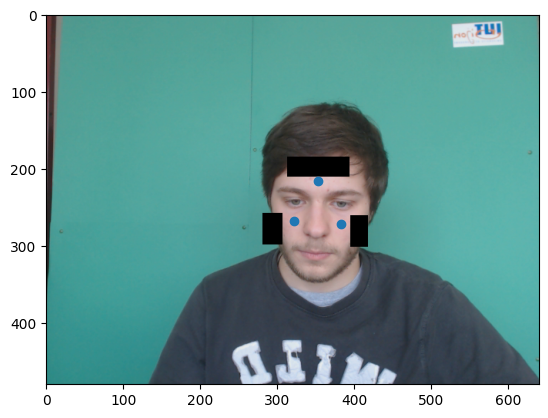

In [23]:
video_array, coordinates_lands = obstraction1(video_RGB, plot_bool=True)

In [ ]:
GT_rPPG = np.array(import_UBFC_RPPG_ground_truth(num_patient=patient))
sample_rate = 30

smooth_freqs, smooth_power_spectrum, GT_HR, max_power = compute_power_spectrum(GT_rPPG[0][:leng], sample_rate,leng)

In [25]:
# Preallocate a DataFrame with NaN values (first iteration)
# columns : ROIs
# rows : GT (ground truth), greemn, ica, pos, chrom
rows = 6
columns = ['fore_head', 'cheek_sx', 'cheek_dx']
#columns = ['p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9']
df = pd.DataFrame(np.nan, index=range(rows), columns=columns)
df1 = pd.DataFrame(np.nan, index=range(rows), columns=columns)
df2 = pd.DataFrame(np.nan, index=range(rows), columns=columns)
df3 = pd.DataFrame(np.nan, index=range(rows), columns=columns)
# Specify the filename
filename = '/content/drive/MyDrive/tesi_UBFC-RPPG/tesi/LPA/obstraction/MAE/skin_lpa_AE_' + str(patient) + '.csv'
filename1 = '/content/drive/MyDrive/tesi_UBFC-RPPG/tesi/LPA/obstraction/RMSE/skin_lpa_SE_' + str(patient) + '.csv'
filename2 = '/content/drive/MyDrive/tesi_UBFC-RPPG/tesi/LPA/obstraction/SNR/skin_lpa_SNR_' + str(patient) + '.csv'
filename3 = '/content/drive/MyDrive/tesi_UBFC-RPPG/tesi/LPA/obstraction/RI/skin_lpa_SNR_' + str(patient) + '.csv'


# Check if the file exists
if os.path.exists(filename):
    print(f"The file '{filename}' exists.")
else:
  print(f"The file '{filename}' does not exist.")
  df.to_csv(filename, index=False)

if os.path.exists(filename1):
    print(f"The file '{filename1}' exists.")
else:
  print(f"The file '{filename1}' does not exist.")
  df.to_csv(filename1, index=False)

if os.path.exists(filename2):
    print(f"The file '{filename2}' exists.")
else:
  print(f"The file '{filename2}' does not exist.")
  df.to_csv(filename2, index=False)

if os.path.exists(filename3):
    print(f"The file '{filename3}' exists.")
else:
  print(f"The file '{filename3}' does not exist.")
  df.to_csv(filename3, index=False)

The file '/content/drive/MyDrive/tesi_UBFC-RPPG/tesi/LPA/obstraction/MAE/skin_lpa_AE_4.csv' exists.
The file '/content/drive/MyDrive/tesi_UBFC-RPPG/tesi/LPA/obstraction/RMSE/skin_lpa_SE_4.csv' exists.
The file '/content/drive/MyDrive/tesi_UBFC-RPPG/tesi/LPA/obstraction/SNR/skin_lpa_SNR_4.csv' exists.
The file '/content/drive/MyDrive/tesi_UBFC-RPPG/tesi/LPA/obstraction/RI/skin_lpa_SNR_4.csv' does not exist.


In [ ]:
signal_RGB = {'R':[],'G':[],'B':[]}
count = 0
#roi selection
for roi in ['cheek_dx','cheek_sx','fore_head']:
  if roi == 'fore_head':
    pp = 151
  elif roi == 'cheek_dx':
    pp = 330
  elif roi == 'cheek_sx':
    pp = 101

  #lpa for each frame
  signal_RGB = {'R':[],'G':[],'B':[]}
  for j in range(video_array.shape[0]): #for each frame
    image = video_array[j] #j-th frame
    x_point, y_point = coordinates_lands[pp][j] #correspondent point to the j-th frame
    par = 0.03

    # LPA
    final_res = FULL(image,y_point,x_point,par) # compute the LPA_ICA on the different channels
    dict_results = merge_channels(final_res,y_point,x_point) # merge the different scale values (simple average)
    c = coordinates(dict_results) # coordinates pixels on the boundary (only along the predefined direction)
    pix_s = pixel1(c,image) # pixel coordinates witin the region identified by the LPA_ICA

    if j == 50:
      plot_region(pix_s,image,temp=True)

    r_val, g_val, b_val = mean_value(pix_s,image)
    signal_RGB['R'].append(r_val)
    signal_RGB['G'].append(g_val)
    signal_RGB['B'].append(b_val)

  #signal extraction (method application)
  result = []
  result1 = []
  result2 = []
  result3 = []
  for met in ['POS','CHROM','GREEN','ICA','PBV','LGI']: # apply the different algorithm on the same ROI
    a,b,c,d = algorithm(signal_RGB,count, GT_HR, method=met, plott=True)
    result.append(a)
    result1.append(b)
    result2.append(c)
    result3.append(d)
  df.loc[0:,roi] = result
  df1.loc[0:,roi] = result1
  df2.loc[0:,roi] = result2
  df3.loc[0:,roi] = result3
  count +=1

In [27]:
df.to_csv(filename, index=False)
df1.to_csv(filename1, index=False)
df2.to_csv(filename2, index=False)
df3.to_csv(filename2, index=False)